In [ ]:
!pip install --upgrade keras tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import Add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

<ipython-input-3-1eb968943597>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [ ]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 2.13.1
TensorFlow version: 2.13.0


Creating 5 different functions to load and prepocess our dataset


1.load_fp( filename ) – To load the document file and read the contents of the file into a string.


2.mg_capt( filename ) – To create a description dictionary that will map images with all 5 captions.


3.txt_cleaning( descriptions) – This method is used to clean the data by taking all descriptions as input. While dealing with textual data we need to perform several types of cleaning including uppercase to lowercase conversion, punctuation removal, and removal of the number containing words.


4.txt_vocab( descriptions ) – This is used to create a vocabulary from all the unique words extracted out from descriptions.


5.save_descriptions( descriptions, filename ) – This function is used to store all the preprocessed descriptions into a file.

In [ ]:
import string

In [ ]:
#  Load the document file into memory
def load_fp(filename):
  # Open file to read
   file = open(filename, 'r')
   text = file.read()
   file.close()
   return text


In [ ]:

#images with captions
def img_capt(filename):
   file = load_fp(filename)
   captions = file.split('\n')
   descriptions ={}
   #dict to store image captions
   for caption in captions[:-1]:
       img, caption= caption.split('\t')
       #splitting each image into image id and caption text
       if img[:-2] not in descriptions:
        #check if image id is not already there in descriptions dictionary
        descriptions[img[:-2]] = [ caption ]
       else:
        #if it is already there, just append it to that particular key
        descriptions[img[:-2]].append(caption)
   return descriptions


#cleaning the text
def txt_clean(captions):
  #  It creates a translation table using the str.maketrans function to remove punctuation from text.
  # The string.punctuation variable contains a string of all punctuation characters.
   table = str.maketrans('','', string.punctuation)
   for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
      img_caption.replace("-"," ")
      #split the captions into words
      descp = img_caption.split()
      #uppercase to lowercase
      descp = [wrd.lower() for wrd in descp]

      #remove punctuation from each token
      descp = [wrd.translate(table) for wrd in descp]

      #remove single letter wordss like 'a'
      descp = [wrd for wrd in descp if(len(wrd)>1)]
      #remove words containing numbers with them
      descp = [wrd for wrd in descp if(wrd.isalpha())]
          #converting back to string
      img_caption = ' '.join(descp)
      captions[img][i]= img_caption
   return captions

def txt_vocab(descriptions):
  # To build vocab of all unique words
  vocab = set()
  # For each key, iterate through the list of descriptions associated with that key.
  for key in descriptions.keys():
    #add unique words to vocab set
    [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

#To save all descriptions in one file
def save_descriptions(descriptions, filename):
   lines = list()
   for key, desc_list in descriptions.items():
    for desc in desc_list:
      # Create a line by concatenating the image ID, a tab character ('\t'), and the description.
      lines.append(key + '\t' + desc )
      # Join the lines into a single string with newline characters ('\n') between them.
      data = "\n".join(lines)
      file = open(filename,"w")
      file.write(data)
      file.close()
filename= '/content/drive/MyDrive/ImageCaptionGenerator/Flickr8k.token.txt'

#loading the file that contains all data
#map them into descriptions dictionary
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")



Length of descriptions = 8092
Length of vocabulary =  8763


KeyboardInterrupt: ignored

In [ ]:
print(descriptions)


{'1000268201_693b08cb0e.jpg': ['child'], 'try way .\n1000268201_693b08cb0e.jpg': ['girl goi'], 'g .\n1000268201_693b08cb0e.jpg': ['little girl climbi'], ' playhouse .\n1000268201_693b08cb0e.jpg': ['little girl climbi'], 'g the stairs to her playhouse .\n1000268201_693b08cb0e.jpg': ['little girl'], ' .\n1001773457_577c3a7d70.jpg': ['black dog'], 'g\n1001773457_577c3a7d70.jpg': ['black dog'], ' the road .\n1001773457_577c3a7d70.jpg': ['black dog', 'two dogs'], ' the street .\n1001773457_577c3a7d70.jpg': ['two dogs of differe'], 'g toward each other .\n1002674143_1b742ab4b8.jpg': ['little girl covered'], ' a bowl .\n1002674143_1b742ab4b8.jpg': ['little girl is sitti'], 'bow .\n1002674143_1b742ab4b8.jpg': ['small girl'], ' it .\n1002674143_1b742ab4b8.jpg': ['there is girl with pigtails sitti'], 'g .\n1002674143_1b742ab4b8.jpg': ['you'], ' the grass .\n1003163366_44323f5815.jpg': ['ma'], 'ch while his dog sits by him .\n1003163366_44323f5815.jpg': ['ma'], 'ch to which a white dog is also ti

In [ ]:
print(clean_descriptions)
print(len(clean_descriptions))

{'1000268201_693b08cb0e.jpg': ['child'], 'try way .\n1000268201_693b08cb0e.jpg': ['girl goi'], 'g .\n1000268201_693b08cb0e.jpg': ['little girl climbi'], ' playhouse .\n1000268201_693b08cb0e.jpg': ['little girl climbi'], 'g the stairs to her playhouse .\n1000268201_693b08cb0e.jpg': ['little girl'], ' .\n1001773457_577c3a7d70.jpg': ['black dog'], 'g\n1001773457_577c3a7d70.jpg': ['black dog'], ' the road .\n1001773457_577c3a7d70.jpg': ['black dog', 'two dogs'], ' the street .\n1001773457_577c3a7d70.jpg': ['two dogs of differe'], 'g toward each other .\n1002674143_1b742ab4b8.jpg': ['little girl covered'], ' a bowl .\n1002674143_1b742ab4b8.jpg': ['little girl is sitti'], 'bow .\n1002674143_1b742ab4b8.jpg': ['small girl'], ' it .\n1002674143_1b742ab4b8.jpg': ['there is girl with pigtails sitti'], 'g .\n1002674143_1b742ab4b8.jpg': ['you'], ' the grass .\n1003163366_44323f5815.jpg': ['ma'], 'ch while his dog sits by him .\n1003163366_44323f5815.jpg': ['ma'], 'ch to which a white dog is also ti

In [ ]:
print(vocabulary)
print(len(vocabulary))

{'playfighti', 'ei', 'pose', 'all', 'ill', 'buries', 'hurdle', 'stop', 'with', 'ghostbuster', 'side', 'yaw', 'quad', 'live', 'nfl', 'rear', 'grabbi', 'primpi', 'she', 'scottish', 'waterskier', 'bea', 'scali', 'hooded', 'hose', 'wearfi', 'excavati', 'sparri', 'awaits', 'located', 'drag', 'ide', 'somebody', 'cute', 'large', 'mug', 'wraps', 'arm', 'pou', 'street', 'presses', 'packed', 'talks', 'childi', 'eve', 'they', 'teammate', 'matchi', 'havi', 'parasail', 'protesters', 'air', 'athletic', 'hiki', 'members', 'reso', 'russel', 'guide', 'pouri', 'crossed', 'bows', 'participa', 'cake', 'martial', 'germa', 'whilst', 'player', 'clergy', 'herd', 'desperate', 'asce', 'disk', 'jumps', 'break', 'looki', 'tow', 'straggle', 'juggle', 'gai', 'yell', 'child', 'fooli', 'spots', 'squirt', 'hairy', 'appear', 'scrambli', 'that', 'overlook', 'lays', 'slalomlike', 'mouthpiece', 'work', 'pilot', 'kicks', 'bite', 'thick', 'blowup', 'shawled', 'course', 'rollerbladi', 'pull', 'stick', 'ya', 'outfit', 'puri',

Extract the Feature Vector

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
#excluding the fully connected layers at the top of the model

#function for extracting features of images from a directrory of images
def extract_features(dirc):
       model = Xception( include_top=False, pooling='avg' )
       features = {}
       for pic in tqdm(os.listdir(dirc)):
           file = dirc + "/" + pic
           image = Image.open(file)
           image = image.resize((299,299))
          # this line adds an extra dimension to the image,
          # effectively converting it from a 2D image to a 3D tensor.
          # The extra dimension corresponds to the batch size (1 in this case),
          # which is typically required when passing an image to a deep learning model.
           image = np.expand_dims(image, axis=0)
           img = image/127.5
           img = img - 1.0
           #xception model is used to predict feautures for the images
           feature = model.predict(img)
           #resulting feauture vector is added to dictionary "features"
           features[pic] = feature
       return features
dataset_images= "/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset"
#2048 feature vector
fileList=os.listdir(dataset_images)
print(len(fileList))
features = extract_features(dataset_images)
#dump function is used to save the features dictionary to filr named features.p in binary write mode
dump(features, open("features.p","wb"))
#to directly load the features from the pickle file.
features = load(open("features.p","rb"))

8091


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 37ms/step


In [ ]:
print(len(fileList))
print(len(features))



8091
8091


Priniting the features dictionary containing image id as "key" and feature vector for that image obtained from extracting features using xception model as "val"

In [ ]:
for key, value in list(features.items())[:5]:
    print(f'Key: {key}, Value: {value}')

Key: 380041023_0dfd712ef1.jpg, Value: [[0.08488669 0.2021947  0.03435428 ... 0.00560211 0.02934122 0.        ]]
Key: 380515798_c2abbf46b0.jpg, Value: [[0.49320373 0.0224559  0.40762597 ... 0.0682592  0.23435722 0.22400405]]
Key: 380527679_574749123d.jpg, Value: [[0.46604234 0.         0.08094659 ... 0.01113862 0.         0.10005537]]
Key: 378170167_9b5119d918.jpg, Value: [[0.01379137 0.0766302  0.         ... 0.0292073  0.         0.01203458]]
Key: 378453580_21d688748e.jpg, Value: [[0.02321158 0.04989472 0.15415922 ... 0.         0.27222118 0.00302012]]


In [ ]:
import shutil

# Move the pickle file to Google Drive
source_path = '/content/features.p'  # Replace with the actual path of your pickle file
destination_path = '/content/drive/MyDrive/ImageCaptionGenerator'  # Replace with your desired destination folder

shutil.move(source_path, destination_path)

'/content/drive/MyDrive/ImageCaptionGenerator/features.p'

In [ ]:
import shutil
# Move the descriptions file to Google Drive
source_path = '/content/descriptions.txt'  # Replace with the actual path of your descriptions file
destination_path = '/content/drive/MyDrive/ImageCaptionGenerator'  # Replace with your desired destination folder

shutil.move(source_path, destination_path)

'/content/drive/MyDrive/ImageCaptionGenerator/descriptions.txt'

Loading the Train and Test Dataset for Model Training

In [ ]:
#load the data
def load_photos(filename):
   file = load_fp(filename)
   #exclude the last empty line in the file
   photos = file.split("\n")[:-1]
   return photos


def load_clean_descriptions(filename, photos):
  #loading clean_descriptions
  file = load_fp(filename)

  descriptions = {}
  for line in file.split("\n"):
    words = line.split()
    # print("Line:", line)
    # # Print the line being processed
    # print("Words:", words)
    # Print the words split from the l
    if len(words)<1 :
      continue
    image, image_caption = words[0], words[1:]
    #checking whether image id is in the photos list
    if image in photos:
      #if this image id is not in descroptions dictionary
      if image not in descriptions:
        #creating a new list for that image id in the dictionary
        descriptions[image] = []
      desc = ' ' + " ".join(image_caption) + ' '
      descriptions[image].append(desc)
  return descriptions


def load_features(photos):
  #loading all features
  all_features = load(open("/content/drive/MyDrive/ImageCaptionGenerator/features.p","rb"))
  #selecting only needed features , iterating thru the keys in photos and selects
  #corresponding features from the all_features dictionary contanining extracted features of images
  features = {k:all_features[k] for k in photos}
  return features



filename = "/content/drive/MyDrive/ImageCaptionGenerator/Flickr_8k.trainImages.txt"

with open(r"/content/drive/MyDrive/ImageCaptionGenerator/Flickr_8k.trainImages.txt", 'r') as fp:
    count = 0
    for line in fp:
        if line != "\n":
            count += 1
print('Total Lines', count)

train_imgs = load_photos(filename)

train_descriptions = load_clean_descriptions("/content/drive/MyDrive/ImageCaptionGenerator/descriptions.txt", train_imgs)
# for image, captions in train_descriptions.items():
#   print(f"Image: {image}")
#   for i, caption in enumerate(captions[:5]):
#     print(f"Caption {i + 1}: {caption}")

# print(len(train_descriptions))


#
train_features = load_features(train_imgs)


Total Lines 6000


In [ ]:
print(len(train_imgs))

6000


In [ ]:
print(len(train_features))

6000


In [ ]:
for key, value in list(train_features.items())[:5]:
    print("Key:", key)
    print("Value:", value)
    print()

Key: 2513260012_03d33305cf.jpg
Value: [[0.         0.44815826 0.         ... 0.17757443 0.00191514 0.00869674]]

Key: 2903617548_d3e38d7f88.jpg
Value: [[0.17660911 0.01287666 0.15669063 ... 0.07796592 0.22157335 0.07919047]]

Key: 3338291921_fe7ae0c8f8.jpg
Value: [[0.28786087 0.         0.         ... 0.         0.08850839 0.        ]]

Key: 488416045_1c6d903fe0.jpg
Value: [[0.4536432  0.         0.         ... 0.00685248 0.         0.        ]]

Key: 2644326817_8f45080b87.jpg
Value: [[0.00466416 0.00331447 0.02121837 ... 0.0794296  0.01354521 0.        ]]



TOKEINIZING THE VOCABULARY

In [ ]:
from keras.preprocessing.text import Tokenizer
from pickle import dump, load

# Function to read descriptions from a file and convert them into a dictionary
def read_descriptions(file_text):
    descriptions = {}
    lines = file_text.strip().split('\n')
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts)>=2:
          image_id = parts[0]
          description = parts[1]
          if image_id in descriptions:
            descriptions[image_id].append(description)
          else:
            descriptions[image_id] = [description]
        else:
            print("not enough lines")
    return descriptions


# Function to convert dictionary to a list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Function to create a tokenizer
def create_tokenizer(descriptions):
    #creating a list of all the caption texts
    desc_list = dict_to_list(descriptions)
    print(desc_list[:6])

    # Create a tokenizer and fitting it on the captions text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)

    return tokenizer

# Example usage to save the tokenizer to a file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))  # Provide a filename for saving the tokenizer


# Calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the reserved 0 index
print("Vocab size:", vocab_size)

# Function to calculate the maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

file_path= '/content/drive/MyDrive/ImageCaptionGenerator/descriptions.txt'
with open(file_path, 'r') as file:
    descriptions_text = file.read()
descriptions = read_descriptions(descriptions_text)

# Example usage to calculate max description length
max_desc_length = max_length(descriptions)
print("Max description length:", max_desc_length)

[' child in pink dress is climbing up set of stairs in an entry way ', ' girl going into wooden building ', ' little girl climbing into wooden playhouse ', ' little girl climbing the stairs to her playhouse ', ' little girl in pink dress going into wooden cabin ', ' black dog and spotted dog are fighting ']
Vocab size: 7577
not enough lines
not enough lines
Max description length: 32


In [ ]:
import shutil
# Move the descriptions file to Google Drive
source_path = '/content/tokenizer.pkl'
destination_path = '/content/drive/MyDrive/ImageCaptionGenerator'

shutil.move(source_path, destination_path)

'/content/drive/MyDrive/ImageCaptionGenerator/tokenizer.pkl'

Creating Data Generator Model


Total 6000 images with 2048 length feature vector and the caption represented as numbers are present in our training sets. It’s not possible to hold such a large amount of data into memory so we are going to use a generator method that will yield batches.



In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            # retrieve photo features
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # divide one sequence into various X,y pairs
        for i in range(1, len(seq)):
            # divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_desc_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    print(len(desc_list))
    return np.array(x_1), np.array(x_2), np.array(y)





In [ ]:
# To check the shape of the input and output for your model
import pickle
features= '/content/drive/MyDrive/ImageCaptionGenerator/features.p'
with open(features, 'rb') as f:
    loaded_features = pickle.load(f)

print(len(loaded_features))


[a, b], c = next(data_generator(train_descriptions, loaded_features, tokenizer, max_length))
a.shape, b.shape, c.shape

8091
5


((37, 2048), (37, 32), (37, 7577))

## Define the CNN-RNN model:}

Feature Extractor –With a dense layer, it will extract the feature from the

images of size 2048 and we will decrease the dimensions to 256 nodes.


Sequence Processor – Followed by the LSTM layer, the textual input is handled by this embedded layer.




Decoder – We will merge the output of the above two layers and process the dense layer to make the final prediction.

In [ ]:
from keras.layers import add
from tensorflow.keras.utils import plot_model

In [ ]:
   inputs1 = Input(shape=(2048,))
   fe1 = Dropout(0.5)(inputs1)
   fe2 = Dense(256, activation='relu')(fe1)
  # LSTM sequence model, input layer for the sequence of words , to predict the next word using LSTM model
   inputs2 = Input(shape=(max_desc_length,))
  #  This line adds an embedding layer that maps words in the caption sequences to 256-dimensional vectors.
   se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
   se2 = Dropout(0.5)(se1)
   se3 = LSTM(256)(se2)
  # Merging both models
   decoder1 = add([fe2, se3])
   decoder2 = Dense(256, activation='relu')(decoder1)
  #  This line generates the final output of the model, which is a dense layer with vocab_size units and softmax activation.
   outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # merge it [image, seq] [word]
   model = Model(inputs=[inputs1, inputs2], outputs=outputs)
   model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
   print(model.summary())
    # This line generates a visual representation of the model architecture and saves it as an image file named "model.png."
   plot_model(model, to_file='model.png', show_shapes=True)
   print(plot_model)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 32, 256)              1939712   ['input_6[0][0]']             
                                                                                                  
 dropout_3 (Dropout)         (None, 2048)                 0         ['input_5[0][0]']             
                                                                                            

In [ ]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
  # features from the CNN model compressed from 2048 to 256 nodes
  #  defines the input layer for the image features. It expects input data with a shape of (2048,), which suggests that it is designed to accept a feature vector of 2048 dimensions
   inputs1 = Input(shape=(2048,))
   fe1 = Dropout(0.5)(inputs1)
   fe2 = Dense(256, activation='relu')(fe1)
  # LSTM sequence model, input layer for the sequence of words , to predict the next word using LSTM model
   inputs2 = Input(shape=(max_length,))
  #  This line adds an embedding layer that maps words in the caption sequences to 256-dimensional vectors.
   se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
   se2 = Dropout(0.5)(se1)
   se3 = LSTM(256)(se2)
  # Merging both models
   decoder1 = add([fe2, se3])
   decoder2 = Dense(256, activation='relu')(decoder1)
  #  This line generates the final output of the model, which is a dense layer with vocab_size units and softmax activation.
   outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # merge it [image, seq] [word]
   model = Model(inputs=[inputs1, inputs2], outputs=outputs)
   model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
   print(model.summary())
    # This line generates a visual representation of the model architecture and saves it as an image file named "model.png."
   plot_model(model, to_file='model.png', show_shapes=True)
   print(plot_model)
   return model

In [ ]:
import shutil
# Move the descriptions file to Google Drive
source_path = '/content/model.png'
destination_path = '/content/drive/MyDrive/ImageCaptionGenerator'

shutil.move(source_path, destination_path)

'/content/drive/MyDrive/ImageCaptionGenerator/model.png'

Training the Image Caption Generator model

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_desc_length)
epochs = 5
steps = len(train_descriptions)
# creating a directory named models to save our models
os.mkdir("models")
for i in range(epochs):
   generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
   model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
   model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  <function max_length at 0x7f529c0f3010>
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 32, 256)              1939712   ['input_8[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 2048)      

<ipython-input-17-d67c6b27c06a>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


Streaming output truncated to the last 5000 lines.
6000/6000 [==============================] - 824s 136ms/step - loss: 4.9371


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
6000/6000 [==============================] - 920s 153ms/step - loss: 3.2852


In [ ]:
import shutil
# Move the descriptions file to Google Drive
source_path = '/content/models'
destination_path = '/content/drive/MyDrive/ImageCaptionGenerator'

shutil.move(source_path, destination_path)

'/content/drive/MyDrive/ImageCaptionGenerator/models'

Testing the model

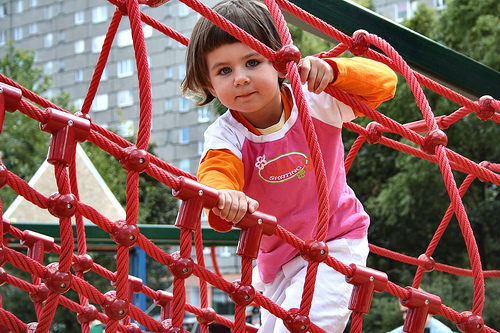

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/ImageCaptionGenerator/Flicker8k_Dataset/1007320043_627395c3d8.jpg')
img